## Ricker Model estimation with approximated likelihood ratios

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.

For this, the Ricker classical populatiol model is used (this model shows near-chaotic dynamics). The ricker model is defined as:
$$ X_{t+1} = rX_t\exp(-X_t + e_t) $$
where $e_t$ is independent with $Normal(0,\sigma^2)$ distribution.
The process is not observed directly, instead samples with poisson distribution are observed.
$$ Y_t = Poisson(\phi X_t) $$
The Ricker model is an example of state space models.
We first only consider the time serie $X$ in order to study parameter estimation using approximated likelihood ratios on time series.
Here, the distribution is only conditioned by the previous value $p(x_t|x_{t-1})$. 
The joint probability distribution is then 
$$p_{x_t,...x_1}(x_t,...x_1;\theta) = \prod_{t=2}^T{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta)} * p_{x_1}(x_1;\theta)$$

or if we keep $x_1$ deterministic, the conditional likelihood can be used instead 
$$\prod_{t=2}^T{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta)}$$ . 

A recurrent neural network trained on the sequences $X' = [{x_t,x_{t-1}}]$ will approximate the posterior probability $p(y_t|x_t,x_{t-1})$ which is monotonic to the ratio $p(x_t|x_{t-1};\theta_0)/ p(x_t|x_{t-1};\theta_1)$

Then to compute the likelihood ratio :
$$\frac{L(\theta_0)}{L(\theta_1)} = \prod_{t=1}^T \frac{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta_0)}{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta_1)}$$
 we can replace the ratios $p(x_t|x_{t-1};\theta_0)/ p(x_t|x_{t-1};\theta_1)$  by the distribution of the score of the trained RNN $p(s([x_t,x_{t-1}])|\theta_0)/ p(s([x_t,x_{t-1}])|\theta_1)$.
 
Then, we can use maximum likelihood on the approximated likelihood ratios (keeping the ratio fixed) in order to estimate the parameters of the time series model.

We start by estimating the parameter $r$ from $\theta = (r,\sigma^2,\phi)$.



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
matplotlib.style.use('ggplot')

np.random.seed(1234)

In [2]:
n_samples = 100000
r_value = 3.8
sigma_2_value = 0.3**2
phi_value = 10.
r_bkg = 5.
shared_r = theano.shared(r_value, name="r")
shared_sigma_2 = theano.shared(sigma_2_value,name="sigma_2")
shared_phi = theano.shared(phi_value, name="phi")

class Ricker:
    def __init__(self,r,sigma_2,phi):
        self.r = r
        self.sigma_2 = sigma_2
        self.phi = phi
    
    def sample(self,r=0.5, sigma_2=1., phi=0.1, start=0.1,n_timesteps=1000, rng=None):
        noise = rng.normal(0.,sigma_2, n_timesteps)
        time_serie = np.zeros(n_timesteps,dtype=np.float64)
        time_serie[0] = np.abs(noise[0])
        r_e = np.exp(r)
        for i in range(1,n_timesteps):
            time_serie[i] = (r_e*time_serie[i-1]*np.exp(-time_serie[i-1] + noise[i]))

        sampled = np.zeros(n_timesteps // 50)
        sampled = np.array([rng.poisson(phi*time_serie[i]) for i in range(0,n_timesteps,50)])
        
        return_serie = time_serie[1:] - time_serie[:-1]
        
        return time_serie.reshape(time_serie.shape[0],1), sampled, return_serie.reshape(return_serie.shape[0],1)
    def rvs(self,n_samples, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        return self.sample(r=self.r.eval(),sigma_2=self.sigma_2.eval(),phi=self.phi.eval(),
                     n_timesteps=n_samples,rng=rng)[0]
                
    
#serie1,sampled1 = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
#serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)

#X_true,X_true_obs = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=1500,start=0.5)


In [3]:
p0 = Ricker(r=shared_r,sigma_2=shared_sigma_2,phi=shared_phi)
#p1 = Ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.)
p1 = Ricker(r = theano.shared(r_bkg, name="r_1"),
            sigma_2 = theano.shared(0.3**2,name="sigma_2_1"),
            phi = theano.shared(10., name="phi_1")
            )
rng = np.random.RandomState(1234)

test_samples = 1000
max_len = 50

X_true = np.array([p0.rvs(max_len, random_state = i) for i in range(test_samples)])
#print X_true

4.25493216603e-05 16.6460280317
1.20768097286e-23 61.9169761923


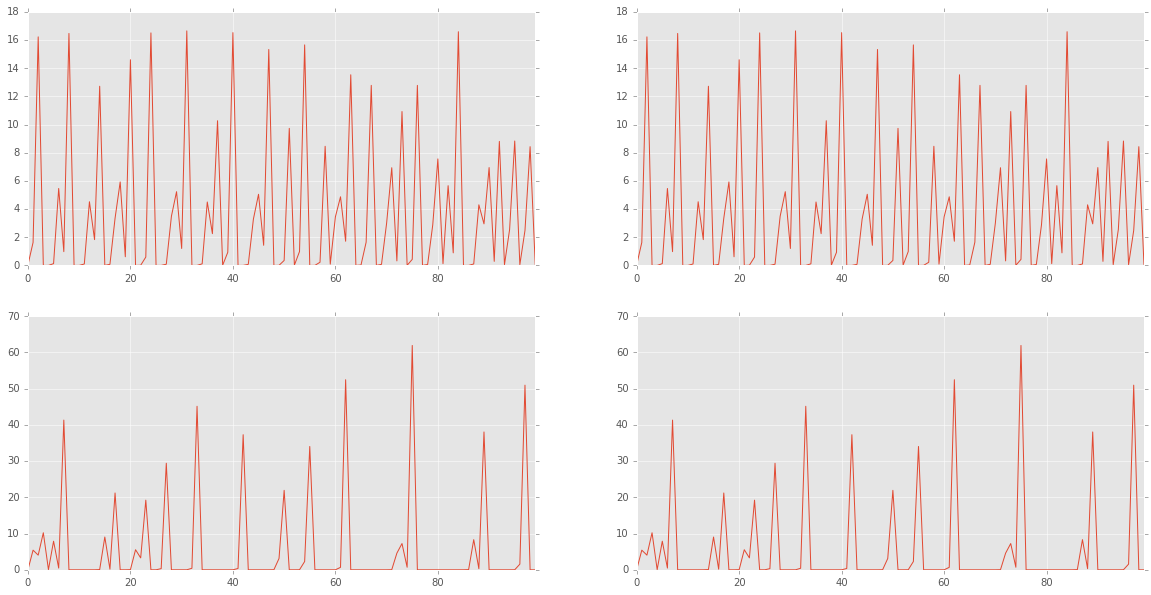

In [4]:
serie1 = p0.rvs(100).ravel()
serie2 = p1.rvs(100).ravel()
plt.figure(figsize=(20,10))
plt.subplot(221)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(222)
ts = pd.Series(serie1)
ts.plot()
plt.subplot(223)
ts = pd.Series(serie2)
ts[0:100].plot()
plt.subplot(224)
ts = pd.Series(serie2)
ts.plot()
print serie1.min(),serie1.max()
print serie2.min(),serie2.max()

In [5]:

import pdb
n_samples = 100000
theta_values = np.linspace(3.,5., num=10)
for k,value in enumerate(theta_values):
    shared_r.set_value(value)
    theta_array = np.empty((max_len,1))
    theta_array.fill(value)
    X0 = np.array([np.hstack((p0.rvs(max_len, random_state=k+i),theta_array)) for i in range(n_samples//2)])
    X1 = np.array([np.hstack((p1.rvs(max_len, random_state=k+i),theta_array)) for i in range(n_samples//2)])
    X_ = np.vstack((X0,X1))
    y_ = np.zeros(X0.shape[0]*2,dtype=np.int)
    y_[X0.shape[0]:] = 1
    X_serie = X_ if k == 0 else np.append(X_serie, X_,axis=0)
    y_serie = y_ if k == 0 else np.append(y_serie, y_,axis=0)



In [6]:
print(X_serie.shape)

(1000000, 50, 2)


In [7]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD


def make_model():
    model = Sequential()
    model.add(GRU(5,input_shape=(max_len,2)))
    model.add(Dropout(0.3))
    model.add(Dense(5,activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    #sgd = SGD(lr=0.01, clipnorm=40.)
    model.compile(loss="binary_crossentropy", optimizer='adam')
    return model


clf = KerasClassifier(make_model, nb_epoch=5, verbose=2)
#clf = make_pipeline(StandardScaler(),as_classifier(clf))

clf.fit(X=X_serie, y=y_serie)
#clf.fit(X=X_serie, y=y_serie,nb_epoch=3,batch_size=32,verbose=2)

Epoch 1/5
224s - loss: 0.1726
Epoch 2/5
224s - loss: 0.1395
Epoch 3/5
224s - loss: 0.1328
Epoch 4/5
223s - loss: 0.1300
Epoch 5/5
222s - loss: 0.1259


Using Theano backend.


In [8]:
print clf.predict_proba(X_serie)

[[  9.99999940e-01   5.33935953e-08]
 [  9.99999940e-01   5.33613225e-08]
 [  9.99999940e-01   5.38580629e-08]
 ..., 
 [  7.22184896e-01   2.77815133e-01]
 [  6.46201730e-01   3.53798240e-01]
 [  2.97037065e-01   7.02962935e-01]]


In [9]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=30, cv='prefit', 
                                         method='histogram'), 
    random_state=0)

cc_direct.fit(X=X_serie,y=y_serie)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x9951cd0>,
            bins=50, cv='prefit', eps=0.1, method='histogram'),
        random_state=0)

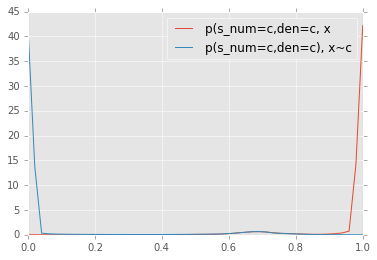

In [10]:
reals2 = np.linspace(0, 1)

cal_num, cal_den = cc_direct.classifier_.calibrators_[0]
plt.plot(reals2, cal_num.pdf(reals2.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x")
plt.plot(reals2, cal_den.pdf(reals2.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()


In [22]:

from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio
import pdb

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

n_samples = 100000
def objective(theta, random_state=0):    
    print(theta)
    shared_r.set_value(theta[0])
    
    theta_array = np.empty((max_len,1))
    theta_array.fill(theta[0])
    X0 = np.array([np.hstack((p0.rvs(max_len, random_state=i),theta_array)) for i in range(n_samples//2)])
    theta_array_1 = np.empty((max_len,1))
    theta_array_1.fill(5.)
    X1 = np.array([np.hstack((p1.rvs(max_len, random_state=i),theta_array_1)) for i in range(n_samples//2)])
    X_serie = np.vstack((X0,X1))
    y_serie = np.zeros(X0.shape[0]*2,dtype=np.int)
    y_serie[X0.shape[0]:] = 1
    
    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=30))
    
    ratio.fit(X_serie, y_serie)
    
    # Evaluate log-likelihood ratio
    Xp = np.empty((X_true.shape))
    Xp[:,:,:] = theta[0]
    X_true_ = np.dstack((X_true, Xp))
    r = ratio.predict(X_true_, log=True)
    #print r[np.isfinite(r)].shape
    zeros = r[np.isinf(r)].shape

    value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                           # this will need to be rescaled by len(X_true)
    print zeros
    print value      
    return value,zeros[0]


In [23]:
n_points = 20
bounds = [(3.3,4.5)]

As = np.linspace(bounds[0][0],bounds[0][1], n_points)

approx_contours = np.zeros(len(As))
zeroes = np.zeros(len(As))
for i,a in enumerate(As):
    approx_contours[i],zeroes[i] = objective([a])
    
approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)

[3.2999999999999998]
(975,)
nan
[3.3631578947368421]
(983,)
nan
[3.426315789473684]
(989,)
nan
[3.4894736842105263]
(996,)
nan
[3.5526315789473681]
(999,)
nan
[3.6157894736842104]
(1000,)
nan
[3.6789473684210527]
(1000,)
nan
[3.7421052631578946]
(1000,)
nan
[3.8052631578947369]
(1000,)
nan
[3.8684210526315788]
(1000,)
nan
[3.9315789473684211]
(1000,)
nan
[3.9947368421052634]
(1000,)
nan
[4.0578947368421048]
(1000,)
nan
[4.1210526315789471]
(1000,)
nan
[4.1842105263157894]
(1000,)
nan
[4.2473684210526317]
(1000,)
nan
[4.310526315789474]
(1000,)
nan
[4.3736842105263154]
(1000,)
nan
[4.4368421052631577]
(1000,)
nan
[4.5]
(1000,)
nan


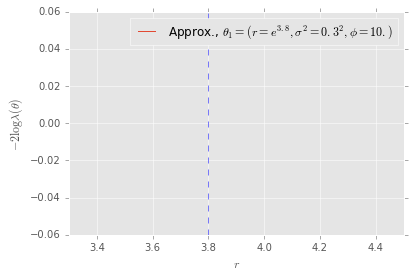

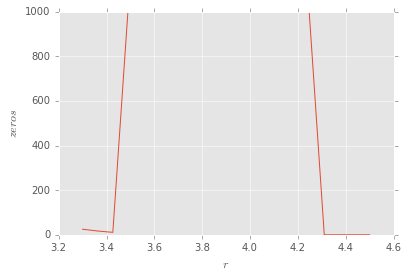

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#print gp_ratios

ax.plot(As, approx_contours, label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=10.)$")
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$-2 \log \lambda(\theta)$")
#plt.legend()

ax.legend()
#ax.set_ylim(-2., 14)
ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=3.8,linestyle='dashed',alpha=0.5)
plt.savefig('likelihood_comp.pdf')
plt.show()
plt.plot(As, zeroes)
plt.xlabel(r"$r$")
plt.ylabel(r"$zeros$")
plt.show()

In [16]:
from GPyOpt.methods import BayesianOptimization
bounds = [(2.5,4.5)]
solver = BayesianOptimization(vectorize(objective), bounds)
solver.run_optimization(max_iter=50, true_gradients=False)

[ 3.37742961]
(14950,)
[ 4.24145422]
(14950,)
[ 4.17344651]
(14950,)
[ 3.73662607]
(14950,)
[ 2.81289675]
(10328,)
[ 2.75003475]
(7684,)
[ 4.4934906]
(14950,)
[ 4.48976552]
(14950,)
[ 4.49403094]
(14950,)
[ 4.47755169]
(14950,)
[ 4.45730935]
(14950,)
[ 4.49285498]
(14950,)
[ 4.49310697]
(14950,)
[ 4.49582428]
(14950,)
[ 4.48565992]
(14950,)
[ 4.49550437]
(14950,)
[ 4.49927371]
(14950,)
[ 4.47917869]
(14950,)
[ 4.45808584]
(14950,)
[ 4.4911567]
(14950,)
[ 4.49782553]
(14950,)
[ 4.49314877]
(14950,)
[ 4.44758782]
(14950,)
[ 4.49662005]
(14950,)
[ 4.45978406]
(14950,)
[ 4.49526844]
(14950,)
[ 4.48252341]
(14950,)
[ 4.47675293]
(14950,)
[ 4.49487648]
(14950,)
[ 4.45257038]
(14950,)
[ 4.42528333]
(14950,)
[ 4.49202583]
(14950,)
[ 4.49344059]
(14950,)
[ 4.4976024]
(14950,)
[ 4.45854746]
(14950,)
[ 4.48600729]
(14950,)
[ 4.47222549]
(14950,)
[ 4.40950661]
(14950,)
[ 4.48989885]
(14950,)
[ 4.49195202]
(14950,)
[ 4.48580283]
(14950,)
[ 4.48043717]
(14950,)
[ 4.44901191]
(14950,)
[ 4.44532493]
(

1

In [17]:
approx_MLE = solver.x_opt
print solver.x_opt
print("Approx. MLE =", approx_MLE)

[ 3.37742961]
('Approx. MLE =', array([ 3.37742961]))


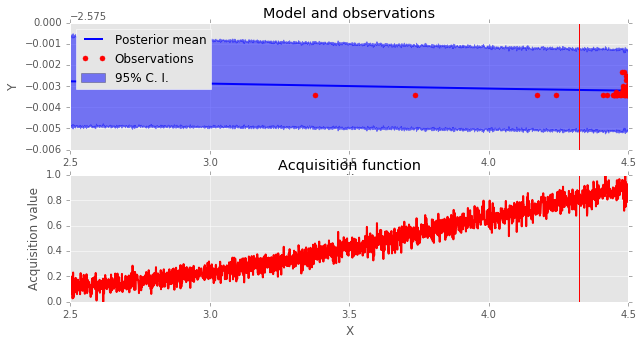

In [18]:
solver.plot_acquisition()

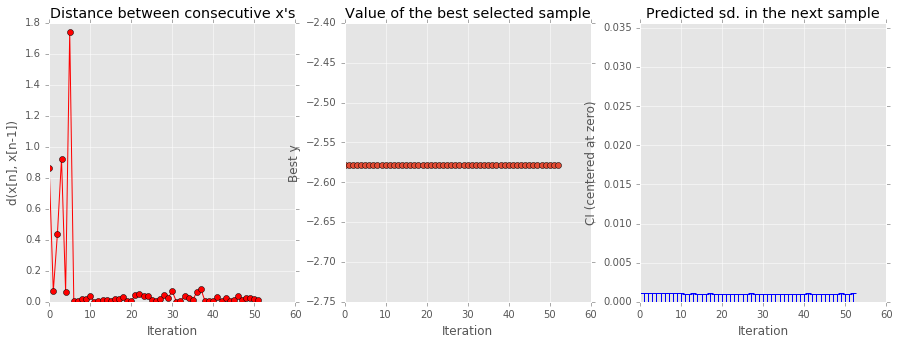

In [19]:
solver.plot_convergence()

In [ ]:
from scipy.optimize import minimize
shared_r.set_value(r_value)
# Minimize the surrogate GP approximate of the approximate LR
def gp_objective(theta):
    theta = theta.reshape(1, -1)
    return solver.model.predict(theta)[0][0]

r = minimize(gp_objective, x0=[np.exp(3.)])
gp_MLE = r.x

print("GP MLE =", gp_MLE)

In [ ]:
#bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16)]
#bounds = [(38., 58.0)]
As = np.linspace(bounds[0][0],bounds[0][1], 50)

n_points = 30

clf = clf
n_samples = n_samples
#As = np.linspace(*bounds[0], 100)
nll_gp, var_gp = solver.model.predict(As.reshape(-1, 1))
nll_gp = 2. * (nll_gp - nll_gp.min()) * len(X_true)
gp_ratios = nll_gp
# STD
std_gp = np.sqrt(4*var_gp*len(X_true)*len(X_true))
std_gp[np.isnan(std_gp)] = 0.
gp_std = std_gp
# 95% CI
q1_gp, q2_gp = solver.model.predict_quantiles(As.reshape(-1, 1))
q1_gp = 2. * (q1_gp - r.fun) * len(X_true)
q2_gp = 2. * (q2_gp - r.fun) * len(X_true)
gp_q1 = q1_gp
gp_q2 = q2_gp

In [ ]:
#bounds = [(42.,46.)]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#print gp_ratios

ax.plot(As, gp_ratios, label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=10.)$")
ax.fill_between(As,(gp_ratios - gp_std).ravel(),(gp_ratios + gp_std).ravel(),
                     color='g',alpha=0.2)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$-2 \log \lambda(\theta)$")
#plt.legend()


ax.legend()
ax.set_ylim(0, 14)
ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=3.8,ymin=0.,ymax=4.,linestyle='dashed',alpha=0.5)
plt.savefig('likelihood_comp.pdf')
plt.show()

TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).

* Check with other parameters
* Try with an easier model e.g simple autoregresive model